# Playground for Clustering Slides

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA
- The Easy version - no hard dependencies or packages (but also, less pretty)

Also see related notebooks:
- `slides_distance_metrics.ipynb`
- `slides_clustering_interpret.ipynb`

In [1]:
import datetime
print(datetime.datetime.now())

2020-11-02 08:28:37.931748


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Default plot settings
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16


plt.rc('figure', figsize=[8.0, 5.0])     # controls the size of the figure
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', grid=True)

# Read in Data

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/main/data/Mall_Customers.csv")

df = df.rename(index=str, columns={"Genre": "Male"})
df['Male'] = df['Male'].replace(['Male', 'Female'], [True, False])
df = df.drop(['CustomerID'], axis=1)
col_names = df.columns

list(df)
df.shape
df.info()
df.describe().transpose()
df.head(n=20)
df.tail()

['Male', 'Age', 'AnnualIncome', 'SpendingScore']

(200, 4)

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Male           200 non-null    bool 
 1   Age            200 non-null    int64
 2   AnnualIncome   200 non-null    int64
 3   SpendingScore  200 non-null    int64
dtypes: bool(1), int64(3)
memory usage: 6.4+ KB


,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
AnnualIncome,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
SpendingScore,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


,Male,Age,AnnualIncome,SpendingScore
0,True,19,15,39
1,True,21,15,81
2,False,20,16,6
3,False,23,16,77
4,False,31,17,40
5,False,22,17,76
6,False,35,18,6
7,False,23,18,94
8,True,64,19,3
9,False,30,19,72


,Male,Age,AnnualIncome,SpendingScore
195,False,35,120,79
196,False,45,126,28
197,True,32,126,74
198,True,32,137,18
199,True,30,137,83


# Select Just Two Features
Instead of working with all four features, let's select just two. This is NOT required, and normally we don't have to do this. We just do it in this beginner tutorial because it will make it easier for us to visualize the clusters, thus aiding our understanding.  

In [5]:
X = df.copy()
X = X.drop(['Age', 'Male'], axis=1)
X.head(10)

,AnnualIncome,SpendingScore
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
5,17,76
6,18,6
7,18,94
8,19,3
9,19,72


# Normalize the Data

In [6]:
scaler = StandardScaler()
features = ['AnnualIncome', 'SpendingScore']
X[features] = scaler.fit_transform(X[features])

In [7]:
X.shape
X.info()
X.describe().transpose()
X.head(10)
X.tail()

(200, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AnnualIncome   200 non-null    float64
 1   SpendingScore  200 non-null    float64
dtypes: float64(2)
memory usage: 4.7+ KB


,count,mean,std,min,25%,50%,75%,max
AnnualIncome,200.0,-2.131628e-16,1.002509,-1.738999,-0.727509,0.035879,0.665675,2.917671
SpendingScore,200.0,-1.465494e-16,1.002509,-1.910021,-0.599793,-0.007764,0.885132,1.894492


,AnnualIncome,SpendingScore
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
5,-1.662660,1.001596
6,-1.624491,-1.715913
7,-1.624491,1.700384
8,-1.586321,-1.832378
9,-1.586321,0.846310


,AnnualIncome,SpendingScore
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054
199,2.917671,1.273347


## Plot the Raw Data

What are we dealing with? What does it look like?

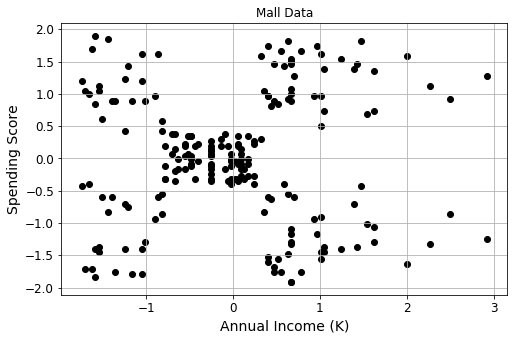

In [8]:
plt.figure();

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c="black");
plt.title("Mall Data");
plt.xlabel('Annual Income (K)');
plt.ylabel('Spending Score');
plt.xticks();
plt.yticks();

# K-Means

The old-fashioned classic.

In [9]:
k_means = KMeans(n_clusters=5, random_state=42)
k_means.fit(X)

KMeans(n_clusters=5, random_state=42)

In [10]:
k_means.labels_

array([3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1,
       3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 4, 1, 4, 2, 4, 2, 4,
       1, 4, 2, 4, 2, 4, 2, 4, 2, 4, 1, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4])

In [11]:
# Let's look at the centers
k_means.cluster_centers_

array([[-1.32954532,  1.13217788],
       [-0.20091257, -0.02645617],
       [ 1.05500302, -1.28443907],
       [-1.30751869, -1.13696536],
       [ 0.99158305,  1.23950275]])

## Internal Validation Metrics

In [12]:
# WCSS == Inertia
k_means.inertia_

65.56840815571681

In [13]:
silhouette_score(X, k_means.labels_)

0.5546571631111091

#### Look at Individual Silhouette Scores
Let's look at the highest and lowest Silhouette Scores

C:\Users\st50\AppData\Roaming\Python\Python36\site-packages\matplotlib\collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


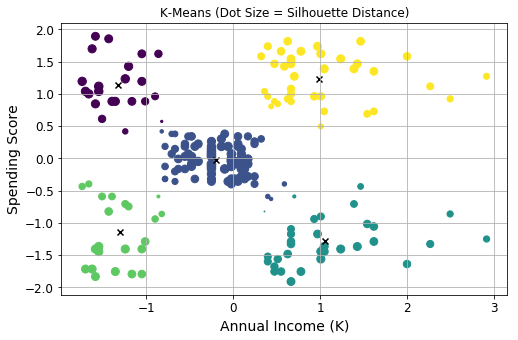

In [14]:
sample_silhouette_values = silhouette_samples(X, k_means.labels_)
sizes = 100*sample_silhouette_values

plt.figure();

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=sizes, c=k_means.labels_)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], marker='x', c="black")

plt.title("K-Means (Dot Size = Silhouette Distance)");
plt.xlabel('Annual Income (K)');
plt.ylabel('Spending Score');

In [15]:
sample_silhouette_values = silhouette_samples(X, k_means.labels_)

X_tmp = X.copy()
X_tmp['Cluster ID'] = k_means.labels_

X_tmp['Silhouette'] = sample_silhouette_values
X_tmp = X_tmp.sort_values(['Silhouette'])
X_tmp.head()
X_tmp.tail()

,AnnualIncome,SpendingScore,Cluster ID,Silhouette
146,0.627505,-0.551266,2,-0.028574
42,-0.822933,-0.551266,3,-0.012125
124,0.360319,-0.823017,2,0.007644
45,-0.822933,0.574559,0,0.049646
40,-0.861102,-0.590088,3,0.090763


,AnnualIncome,SpendingScore,Cluster ID,Silhouette
96,-0.021375,-0.124229,1,0.748039
80,-0.250391,0.031057,1,0.749005
99,0.016795,-0.046586,1,0.749127
97,-0.021375,-0.007764,1,0.754296
92,-0.021375,-0.046586,1,0.759066


## Intepretting the Clusters

There are a few different ways to help us, as humans, interpret the resulting clusters.

#### First, Look at the Cluster Means

In [16]:
# In the case of K-Means, the cluster centers *are* the feature means - that's how K-Means is defined! Sweet!
scaler.inverse_transform(k_means.cluster_centers_)

array([[25.72727273, 79.36363636],
       [55.2962963 , 49.51851852],
       [88.2       , 17.11428571],
       [26.30434783, 20.91304348],
       [86.53846154, 82.12820513]])

#### Example Instances

In [17]:
# Let's look at some example rows in each.
for label in set(k_means.labels_):
    print('\nCluster {}:'.format(label))
    print(scaler.inverse_transform(X[k_means.labels_==label].head()))


Cluster 0:
[[15. 81.]
 [16. 77.]
 [17. 76.]
 [18. 94.]
 [19. 72.]]

Cluster 1:
[[39. 61.]
 [40. 55.]
 [40. 47.]
 [40. 42.]
 [40. 42.]]

Cluster 2:
[[70. 29.]
 [71. 11.]
 [71.  9.]
 [73.  5.]
 [73.  7.]]

Cluster 3:
[[15. 39.]
 [16.  6.]
 [17. 40.]
 [18.  6.]
 [19.  3.]]

Cluster 4:
[[69. 91.]
 [70. 77.]
 [71. 95.]
 [71. 75.]
 [71. 75.]]


#### Plot the Instances with Color=Cluster ID

Since we only have two features, might as well plot the data and color each point by their assigned cluster ID!

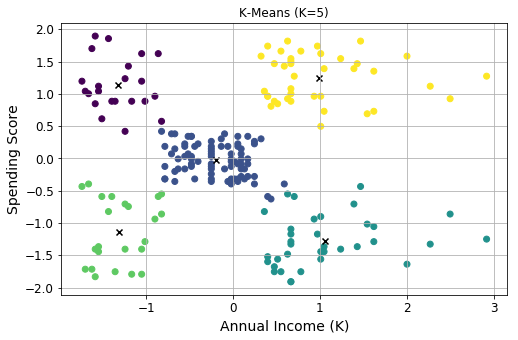

In [18]:
plt.figure();
sc = plt.scatter(X.iloc[:, 0], X.iloc[:, 1],  c=k_means.labels_);
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], marker='x', c="black");
plt.title("K-Means (K=5)");
plt.xlabel('Annual Income (K)');
plt.ylabel('Spending Score');

#### Snakeplot

C:\Users\st50\AppData\Roaming\Python\Python36\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


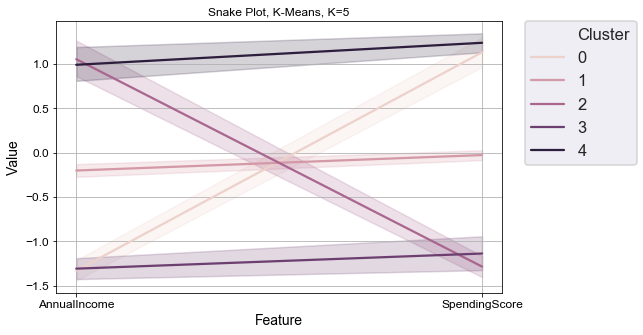

In [19]:
import seaborn as sns

X_df = pd.DataFrame(X, columns=col_names)
X_df['Cluster'] = k_means.labels_
X_df.head()

X_df_melt = pd.melt(X_df,
    id_vars=['Cluster'],
    value_vars=['AnnualIncome', 'SpendingScore'],
    var_name='Feature',
    value_name='Value')

plt.title('Snake Plot, K-Means, K=5');
sns.set(style="darkgrid");
sns.set_context("talk");
sns.lineplot(x="Feature", y="Value", hue='Cluster', data=X_df_melt, legend="full");
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
#plt.savefig('out/mall_heatmap.png', bbox_inches = "tight")

## Hyperparameter Tuning

#### Experiment with Lots of Ks

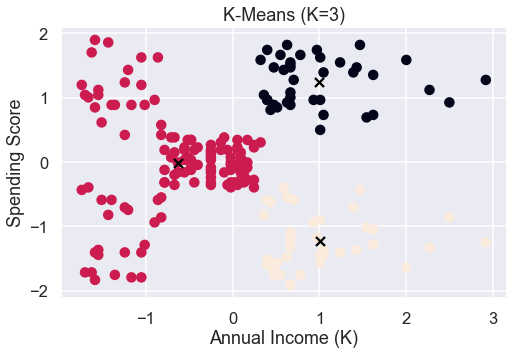

K=3, WCSS=157.70, Sil=0.47


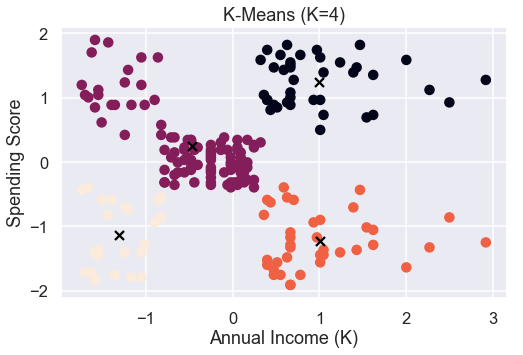

K=4, WCSS=108.92, Sil=0.49


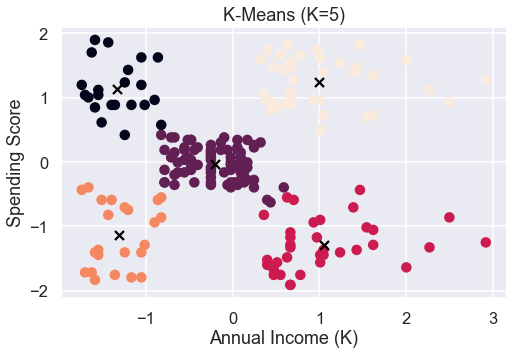

K=5, WCSS=65.57, Sil=0.55


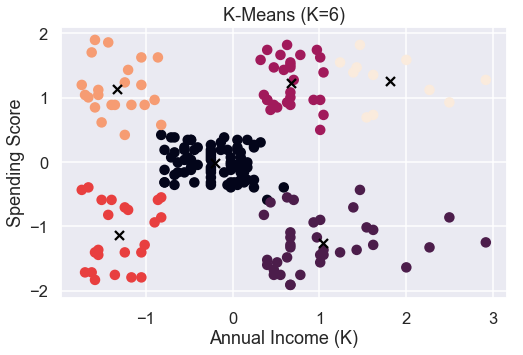

K=6, WCSS=55.11, Sil=0.54


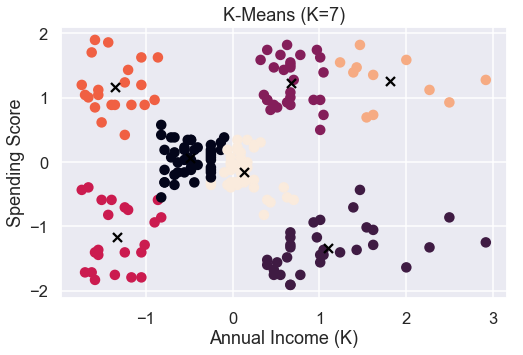

K=7, WCSS=46.86, Sil=0.45


In [20]:
def do_kmeans(X, k):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=42)
    k_means.fit(X)

    plt.figure();
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_)
    plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], marker='x', c="black")
    plt.title("K-Means (K={})".format(k));
    plt.xlabel('Annual Income (K)');
    plt.ylabel('Spending Score');
    #plt.savefig('out/simple_kmeans_k{}.png'.format(k))
    plt.show()
    
    wcss = k_means.inertia_
    sil = silhouette_score(X, k_means.labels_)
    print("K={}, WCSS={:.2f}, Sil={:.2f}".format(k, wcss, sil))

for k in range(3, 8):
    do_kmeans(X, k)

#### The Elbow Method
The Elbow Method can help us choose the best values for hyperparameters, in this case, `K`

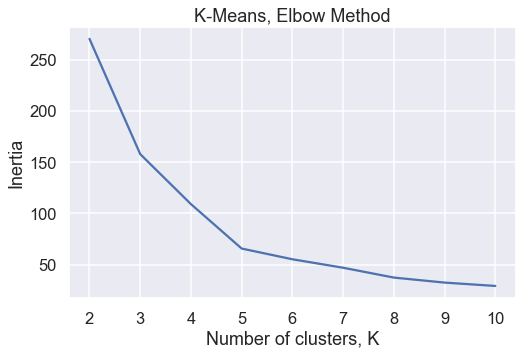

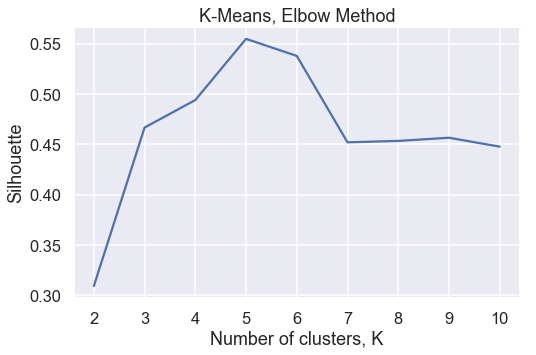

In [21]:
inertias = {}
silhouettes = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouettes[k] = silhouette_score(X, kmeans.labels_, metric='euclidean')
    

plt.figure();
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");


plt.figure();
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

# DBSCAN

In [22]:
db = DBSCAN(eps=0.3, min_samples=3)
db.fit(X)

DBSCAN(eps=0.3, min_samples=3)

In [23]:
db.labels_

array([ 0,  1,  2,  1,  0,  1,  2,  3,  2,  1,  2,  3,  2,  1,  2,  1,  0,
        1,  0,  3,  0,  1,  2,  1,  4,  1,  0, -1,  0,  1,  2,  1,  2,  1,
        4,  1,  4,  1,  5,  1,  5,  1,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  6,  5,  6,  5,  6,  7,  6,  7,  6,  5,  6,  7,  6,
        7,  6,  7,  6,  7,  6,  5,  6,  7,  6,  5,  6,  7,  6,  7,  6,  7,
        6,  7,  6,  7,  6,  7,  6,  5,  6,  7,  6,  8,  6,  8,  6,  8,  6,
        8,  6,  8,  6,  8,  6,  8,  6,  8,  6, -1,  6,  8,  6, -1, -1,  8,
       -1,  8,  6,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [24]:
silhouette_score(X, db.labels_)

0.4136187833583574

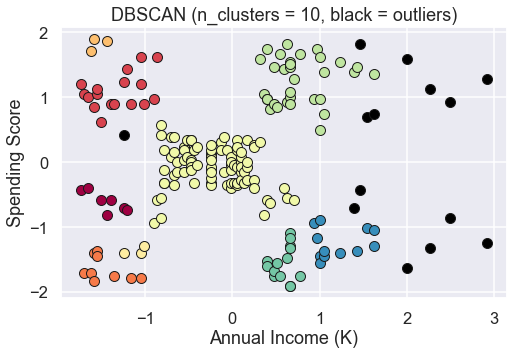

In [25]:
plt.figure();

unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))];

for k in unique_labels:
    if k == -1:        # Black used for noise.
        col = [0, 0, 0, 1]
    else:
        col = colors[k]

    xy = X[db.labels_ == k]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10);

    
plt.title('');
plt.title("DBSCAN (n_clusters = {:d}, black = outliers)".format(len(unique_labels)));
plt.xlabel('Annual Income (K)');
plt.ylabel('Spending Score');

## Elbow Method

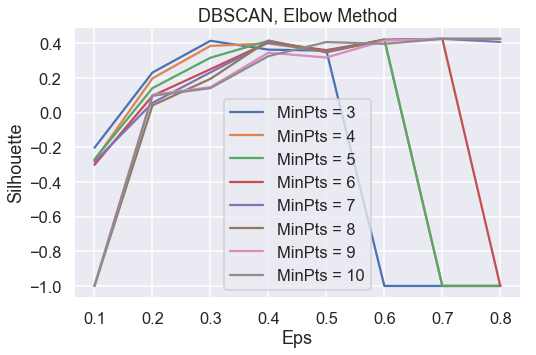

In [26]:
silhouettes = {}

epss = np.arange(0.1, 0.9, 0.1)
minss = [3, 4, 5, 6, 7, 8, 9, 10]

ss = np.zeros((len(epss), len(minss)))

for i, eps in enumerate(epss):
    for j, mins in enumerate(minss):
        db = DBSCAN(eps=eps, min_samples=mins).fit(X)
        if len(set(db.labels_)) == 1:
            ss[i, j] = -1
        else:
            ss[i, j] = silhouette_score(X, db.labels_, metric='euclidean')
    

plt.figure();
#plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
for i in range(len(minss)):
    plt.plot(epss, ss[:, i], label="MinPts = {}".format(minss[i]));
#plt.plot(epss, ss[:, 1]);
plt.title('DBSCAN, Elbow Method')
plt.xlabel("Eps");
plt.ylabel("Silhouette");
plt.legend();
#plt.savefig('out/simple_dbscan_elbow');

## Parameter Exploration

eps=0.3, min_samples=2, n_clusters=11, sil=0.3745966900645067


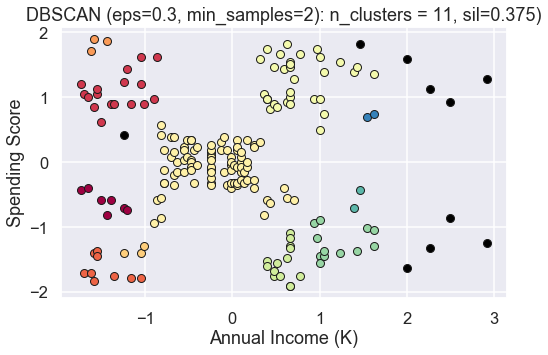

eps=0.1, min_samples=3, n_clusters=14, sil=-0.20308391205535767


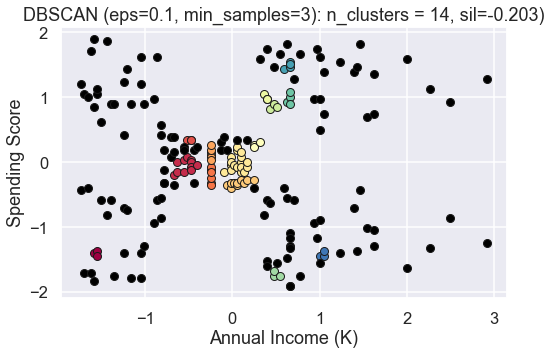

eps=0.3, min_samples=3, n_clusters=9, sil=0.4136187833583574


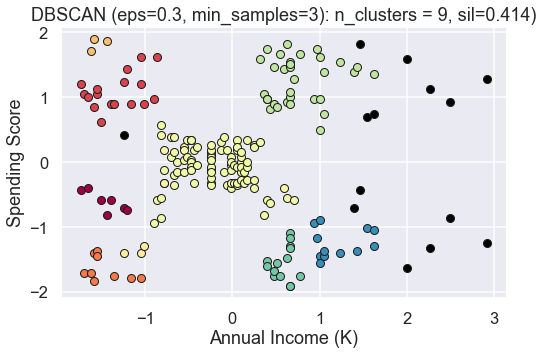

eps=0.6, min_samples=3, n_clusters=0, sil=-1


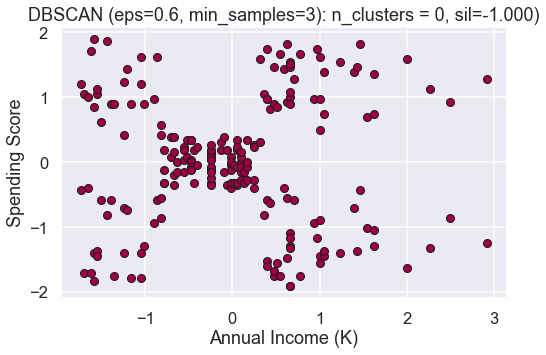

eps=0.6, min_samples=7, n_clusters=1, sil=-1


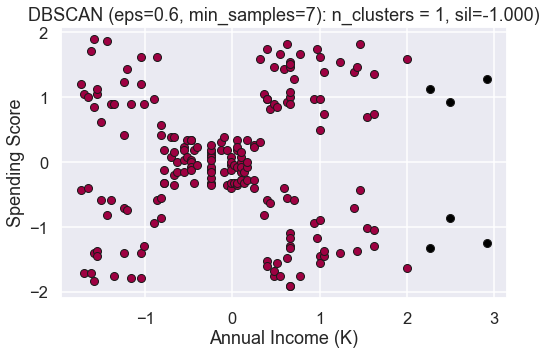

eps=0.36, min_samples=3, n_clusters=7, sil=0.48100287298496186


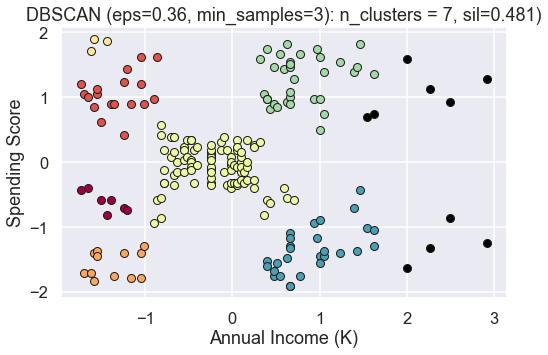

In [27]:
def do_and_plot_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

    unique_labels = set(db.labels_)
    n_clusters = len(unique_labels) - 1
    
    if n_clusters <= 1:
        #print('eps={}, min_samples={}, n_clusters <= 1. Returning.'.format(eps, min_samples))
        #return
        sil = -1
    else:
        sil = silhouette_score(X, db.labels_)
    
    print("eps={}, min_samples={}, n_clusters={}, sil={}".format(eps, min_samples, n_clusters, sil))
    
    plt.figure();
    
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))];

    for k in unique_labels:
        if k == -1:        # Black used for noise.
            col = [0, 0, 0, 1]
        else:
            col = colors[k]

        xy = X[db.labels_ == k]
        plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=8);


    plt.title('');
    plt.title("DBSCAN (eps={}, min_samples={}): n_clusters = {:d}, sil={:.3f})".format(eps, min_samples, n_clusters, sil));
    plt.xlabel('Annual Income (K)');
    plt.ylabel('Spending Score');
    #plt.savefig('out/simple_dbscan_{}_{}.png'.format(eps, min_samples))
    plt.show()


do_and_plot_dbscan(X, 0.3, 2)
do_and_plot_dbscan(X, 0.1, 3)
do_and_plot_dbscan(X, 0.3, 3)
do_and_plot_dbscan(X, 0.6, 3)
do_and_plot_dbscan(X, 0.6, 7)
do_and_plot_dbscan(X, 0.36, 3)

# Hierarchical (Agglomerative)

In [28]:
agg = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg.fit(X)

AgglomerativeClustering(n_clusters=5)

In [29]:
agg.labels_

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1,
       2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

In [30]:
silhouette_score(X, agg.labels_)

0.5538089226688662

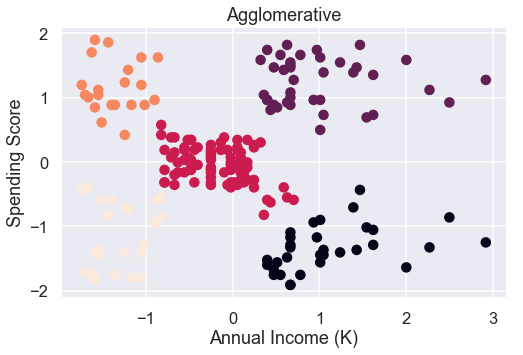

In [31]:
plt.figure();

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=agg.labels_);
plt.title("Agglomerative");
plt.xlabel('Annual Income (K)');
plt.ylabel('Spending Score');

## Dendograms, Linkages, and Distance Metrics

Note that scikit learn does not itself currently support plotting dendograms. Instead, we'll use SciPy's `cluster.hierarchy` module to re-do the clustering, and plot the dendogram.

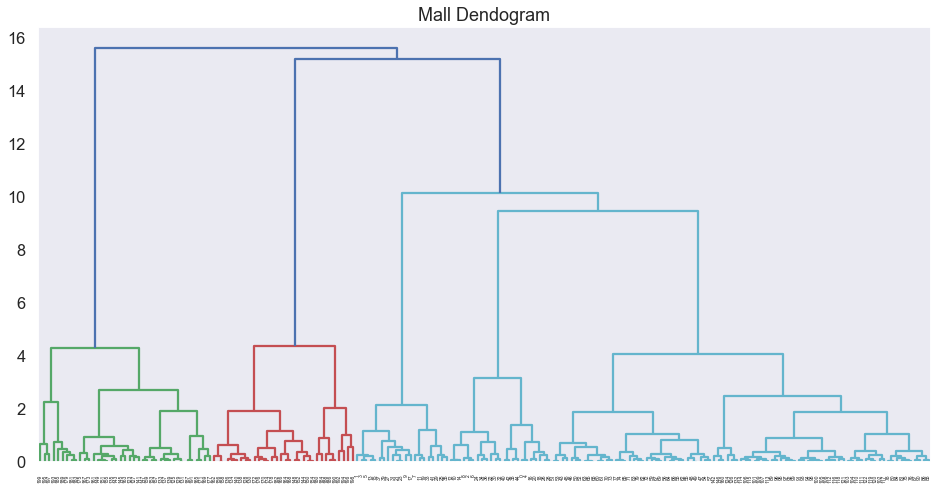

In [32]:
import scipy.cluster

aggl = scipy.cluster.hierarchy.linkage(X, method='ward', metric='euclidean')

# Plot the dendogram
plt.figure(figsize=(16, 8));
plt.grid(False)
plt.title("Mall Dendogram");  
dend = scipy.cluster.hierarchy.dendrogram(aggl); 

# Gaussian Mixture Models (GMM)

In [33]:
gmm = GaussianMixture(n_components=5, covariance_type='full').fit(X)

labels = gmm.predict(X)
silhouette_score(X, labels)

0.5536892843811245

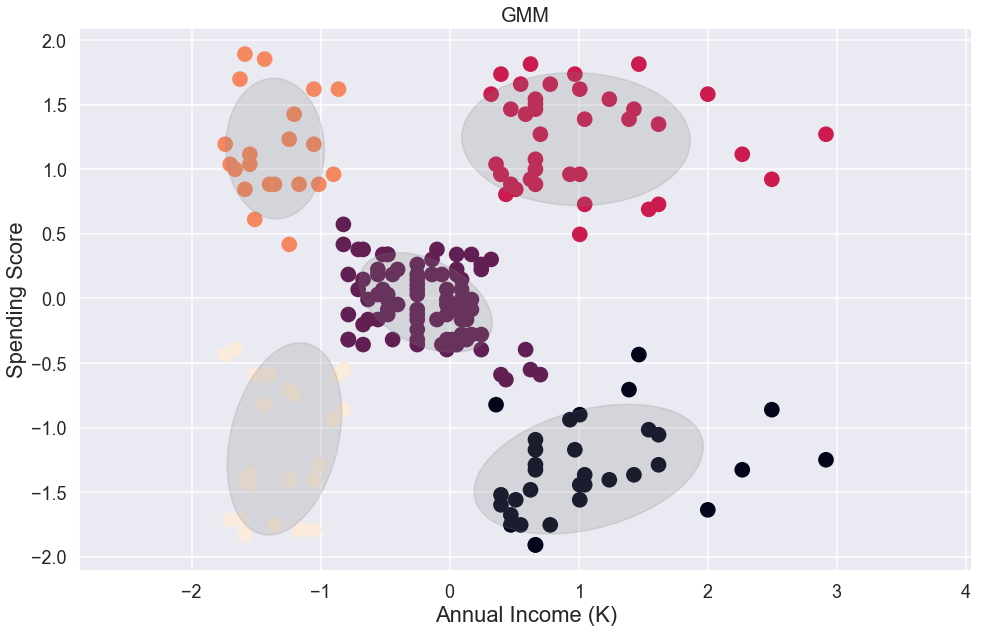

In [34]:
# From:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
import matplotlib as mpl

def make_ellipses(gmm, ax):
    for n, label in enumerate(set(labels)):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color='grey')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.2)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

plt.figure(figsize=(16, 10));
plt.grid(True);

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=200, c=labels);
make_ellipses(gmm, plt.gca())
plt.title("GMM", fontsize=20);
plt.xlabel('Annual Income (K)', fontsize=22);
plt.ylabel('Spending Score', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);